In [1]:
import data_get
import geoist
import torch
import pandas as pd
import numpy as np
import pathlib
from torch import nn
from geoist.inversion.mesh import PrismMesh
from geoist.inversion import geometry
from geoist.pfm import prism
from geoist import gridder
from pathos.multiprocessing import Pool
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as colors
from matplotlib import rcParams
from matplotlib import cm
import os
import geoist.inversion.toeplitz as tptz

In [2]:
class GravDecoder(nn.Module):
    '''Our density model is devided into cubics.
    Args:
        dxyz (tuple of numbers): dimension of each cubic in meters.

    Attributes:
        dxyz (tuple of numbers): dimension of each cubic in meters.
        nxyz (tuple of int): number of cell along each axis.
        G_const (double): Gravity constant in SI unit. 
        cell_volume (double): Volume of each cell in SI unit.
        GV (double): Product of cell volume and Gravity constant.
        kernel_eigs (Tensor): eigs of kernel matrix.
    '''
    def __init__(self, dzyx=(50.,100.,100.),nzyx=(32,96,96), depth_z = -1, data_dir='./models'):
        super(GravDecoder, self).__init__()
        self._name = 'GravDecoder'
        self.dzyx = dzyx
        self.nzyx = nzyx 
        self.G_const = 6.674e-11
        self.cell_volume = np.prod(self.dzyx)
        self.GV = self.G_const * self.cell_volume
        self.data_dir = data_dir
        self.depth_z  = depth_z

    def forward(self,data_input):
        '''Calculate gravity field from density model
        Args:
        data_input (Tensor): density model, with shape (nbatch,nz,ny,nx)

        Return:
        res (Tensor): field of each layer generated by the input density model, with shape
                      (nbatch,nz,ny,nx)
        '''
        data_input = data_input.unsqueeze(0)
        final_res = torch.zeros_like(data_input)
        for ilayer in range(data_input.shape[1]):
            res = torch.zeros((data_input.shape[0],
                               2*self.nzyx[1],
                               2*self.nzyx[2],
                               2),device=self.kernel_eigs.device)
            expand_v = torch.zeros((data_input.shape[0],
                                    2*data_input.shape[2],
                                    2*data_input.shape[3],
                                    2),
                                   device=self.kernel_eigs.device,
                                   dtype=torch.double)
            expand_v[:,:self.nzyx[1],:self.nzyx[2],0] = data_input[:,ilayer,:,:]
            eigs_layer_i = expand_v.fft(2,normalized=True)
            
            tmp_0 = (eigs_layer_i[:,:,:,0] * self.kernel_eigs[ilayer,:,:,0]
                     -eigs_layer_i[:,:,:,1] * self.kernel_eigs[ilayer,:,:,1])
            tmp_1 = (eigs_layer_i[:,:,:,0] * self.kernel_eigs[ilayer,:,:,1]
                     +eigs_layer_i[:,:,:,1] * self.kernel_eigs[ilayer,:,:,0])
            res[:,:,:,0] = tmp_0
            res[:,:,:,1] = tmp_1
            res = res.ifft(2,normalized=True)

            shape = res.shape
            final_res[:,ilayer,:,:] = res[:,:shape[1]//2,:shape[2]//2,0]
            field = torch.sum(final_res,axis=1).squeeze(0)
        return field
        
    def gen_kernel_eigs(self, depthz = -1):
        fname = '{}x{}x{}_{:.0f}x{:.0f}x{:.0f}_lbl.pt'.format(*self.nzyx,*self.dzyx)
        #fname = pathlib.Path(pathlib.Path(self.data_dir)/pathlib.Path(fname))
        fname = pathlib.Path(pathlib.Path(self.data_dir)/pathlib.Path(fname))
        if fname.is_file():
            kernel_eigs = torch.load(fname)
        else:
            density = np.ones((self.nzyx[1],self.nzyx[2]))*1.0e3
            kernel_eigs = torch.empty(self.nzyx[0],2*self.nzyx[1],2*self.nzyx[2],2)
            for i in range(self.nzyx[0]): #垂向分层
                # first generate geometries
                source_volume = [-self.nzyx[2]*self.dzyx[2]/2,
                                 self.nzyx[2]*self.dzyx[2]/2,
                                 -self.nzyx[1]*self.dzyx[1]/2,
                                 self.nzyx[1]*self.dzyx[1]/2,
                                 20+self.dzyx[0]*i,
                                 20+self.dzyx[0]*(i+1)]
                mesh = PrismMesh(source_volume,(1,self.nzyx[1],self.nzyx[2]))
                mesh.addprop('density',density.ravel())
                obs_area = (source_volume[0]+0.5*self.dzyx[2],
                            source_volume[1]-0.5*self.dzyx[2],
                            source_volume[2]+0.5*self.dzyx[1],
                            source_volume[3]-0.5*self.dzyx[1])
                obs_shape = (self.nzyx[2],self.nzyx[1])
                xp,yp,zp = gridder.regular(obs_area,obs_shape,z=-1)
                # then generate the kernel matrix operator.
                def calc_kernel(i):
                    return prism.gz(xp[0:1],yp[0:1],zp[0:1],[mesh[i]])
                with Pool(processes=16) as pool:
                    kernel0 = pool.map(calc_kernel,range(len(mesh)))
                kernel0 = np.array(kernel0).reshape(1,self.nzyx[1],self.nzyx[2])
                kernel_op = tptz.GToepOperator(kernel0)
                kernel_eigs[i,:,:,0] = torch.as_tensor(kernel_op.eigs[0].real,dtype=torch.float32)
                kernel_eigs[i,:,:,1] = torch.as_tensor(kernel_op.eigs[0].imag,dtype=torch.float32)
            torch.save(kernel_eigs,fname)
        self.register_buffer('kernel_eigs',kernel_eigs)

In [3]:
class GravDecoder_changedepth(nn.Module):
    '''Our density model is devided into cubics.
    Args:
        dxyz (tuple of numbers): dimension of each cubic in meters.

    Attributes:
        dxyz (tuple of numbers): dimension of each cubic in meters.
        nxyz (tuple of int): number of cell along each axis.
        G_const (double): Gravity constant in SI unit. 
        cell_volume (double): Volume of each cell in SI unit.
        GV (double): Product of cell volume and Gravity constant.
        kernel_eigs (Tensor): eigs of kernel matrix.
    '''
    def __init__(self, dzyx=(50.,100.,100.),nzyx=(32,96,96), depth_z = -1, data_dir='./models'):
        super(GravDecoder_changedepth, self).__init__()
        self._name = 'GravDecoder_changedepth'
        self.dzyx = dzyx
        self.nzyx = nzyx 
        self.G_const = 6.674e-11
        self.cell_volume = np.prod(self.dzyx)
        self.GV = self.G_const * self.cell_volume
        self.data_dir = data_dir
        self.depth_z  = depth_z

    def forward(self,data_input):
        '''Calculate gravity field from density model
        Args:
        data_input (Tensor): density model, with shape (nbatch,nz,ny,nx)

        Return:
        res (Tensor): field of each layer generated by the input density model, with shape
                      (nbatch,nz,ny,nx)
        '''
        data_input = data_input.unsqueeze(0)
        final_res = torch.zeros_like(data_input)
        for ilayer in range(data_input.shape[1]):
            res = torch.zeros((data_input.shape[0],
                               2*self.nzyx[1],
                               2*self.nzyx[2],
                               2),device=self.kernel_eigs.device)
            expand_v = torch.zeros((data_input.shape[0],
                                    2*data_input.shape[2],
                                    2*data_input.shape[3],
                                    2),
                                   device=self.kernel_eigs.device,
                                   dtype=torch.double)
            expand_v[:,:self.nzyx[1],:self.nzyx[2],0] = data_input[:,ilayer,:,:]
            eigs_layer_i = expand_v.fft(2,normalized=True)
            
            tmp_0 = (eigs_layer_i[:,:,:,0] * self.kernel_eigs[ilayer,:,:,0]
                     -eigs_layer_i[:,:,:,1] * self.kernel_eigs[ilayer,:,:,1])
            tmp_1 = (eigs_layer_i[:,:,:,0] * self.kernel_eigs[ilayer,:,:,1]
                     +eigs_layer_i[:,:,:,1] * self.kernel_eigs[ilayer,:,:,0])
            res[:,:,:,0] = tmp_0
            res[:,:,:,1] = tmp_1
            res = res.ifft(2,normalized=True)

            shape = res.shape
            final_res[:,ilayer,:,:] = res[:,:shape[1]//2,:shape[2]//2,0]
            field = torch.sum(final_res,axis=1).squeeze(0)
        return field
        
    def gen_kernel_eigs(self, depthz = -1):

        dep_abs = str(depthz)
        fname = '{}x{}x{}_{:.0f}x{:.0f}x{:.0f}x{}_lbl.pt'.format(*self.nzyx,*self.dzyx, dep_abs)
        fname = pathlib.Path(pathlib.Path(self.data_dir)/pathlib.Path(fname))
        if fname.is_file():
            kernel_eigs = torch.load(fname)
        else:
            density = np.ones((self.nzyx[1],self.nzyx[2]))*1.0e3
            kernel_eigs = torch.empty(self.nzyx[0],2*self.nzyx[1],2*self.nzyx[2],2)
            for i in range(self.nzyx[0]): #垂向分层
                    # first generate geometries
                source_volume = [-self.nzyx[2]*self.dzyx[2]/2,
                                self.nzyx[2]*self.dzyx[2]/2,
                                -self.nzyx[1]*self.dzyx[1]/2,
                                self.nzyx[1]*self.dzyx[1]/2,
                                20+self.dzyx[0]*i,
                                20+self.dzyx[0]*(i+1)]
                mesh = PrismMesh(source_volume,(1,self.nzyx[1],self.nzyx[2]))
                mesh.addprop('density',density.ravel())
                obs_area = (source_volume[0]+0.5*self.dzyx[2],
                                source_volume[1]-0.5*self.dzyx[2],
                                source_volume[2]+0.5*self.dzyx[1],
                                source_volume[3]-0.5*self.dzyx[1])
                obs_shape = (self.nzyx[2],self.nzyx[1])
                xp,yp,zp = gridder.regular(obs_area,obs_shape,z=depthz)
                    # then generate the kernel matrix operator.
                def calc_kernel(i):
                    return prism.gz(xp[0:1],yp[0:1],zp[0:1],[mesh[i]])
                with Pool(processes=16) as pool:
                    kernel0 = pool.map(calc_kernel,range(len(mesh)))
                kernel0 = np.array(kernel0).reshape(1,self.nzyx[1],self.nzyx[2])
                kernel_op = tptz.GToepOperator(kernel0)
                kernel_eigs[i,:,:,0] = torch.as_tensor(kernel_op.eigs[0].real,dtype=torch.float32)
                kernel_eigs[i,:,:,1] = torch.as_tensor(kernel_op.eigs[0].imag,dtype=torch.float32)
            torch.save(kernel_eigs,fname)
        self.register_buffer('kernel_eigs',kernel_eigs)

In [4]:
pgf_config = {
    "font.family":'serif',
    "font.size": 14,
    "pgf.rcfonts": False,
    #"text.usetex": True,
    "pgf.preamble": [
        r"\usepackage{unicode-math}",
        #r"\setmathfont{XITS Math}", 
        # 这里注释掉了公式的XITS字体，可以自行修改
        r"\setmainfont{Times New Roman}",
        r"\usepackage{xeCJK}",
        r"\xeCJKsetup{CJKmath=true}",
        r"\setCJKmainfont{SimSun}",
    ],
}
rcParams.update(pgf_config)
def Model(m, w, filename = "density"):
    m = m.T
    L, W, H= m.shape
    c = ["#D1FEFE", "#D1FEFE", "#00FEF9", "#00FDFE", "#50FB7F", "#D3F821", "#FFDE00", "#FF9D00", "#F03A00", "#E10000"]
    x, y, z = np.indices((L, W, H))
    model = (x < 0) & (y < 0) & (z < 0)
    color = np.empty(m.shape, dtype=object)
    for i in range(L):
        for j in range(W):
            for k in range(H):
                if m[i][j][k] >= w and m[i][j][k] <=1:
                    cube = (x > i-1) & (x <= i)& (y > j-1) & (y <= j) & (z > k-1) & (z <= k)
                    color[cube] = c[int(round(10*m[i][j][k]))-1]
                    model = model | cube
    plt_model(model, color, filename)

def plt_model(model, facecolors, filename = "density"):
    fig = plt.figure(figsize = (12, 12))
    ax = fig.gca(projection='3d')
    ax.voxels(model, facecolors=facecolors)
    ticks = []
    for i in range(65):
        ticks.append("")
    ticks[0] = -16
    ticks[16] = -8
    ticks[32] = 0
    ticks[48] = 8
    ticks[64] = 16
    fontsize = 18
    ax.tick_params(pad = 10)
    plt.xticks(np.arange(0, 65, 1), ticks, fontsize = fontsize)
    ax.set_xlabel('Easting (Km)', labelpad=2)
    plt.yticks(np.arange(0, 65, 1), ticks, fontsize = fontsize)
    ax.set_ylabel('Northing (Km)', labelpad=2)
    
    zticks = []
    for i in range(33):
        zticks.append("")
    zticks[0] = 0
    zticks[8] = -0.4
    zticks[16] = -0.8
    zticks[24] = -1.2
    zticks[32] = -1.6
    
    ax.set_zticks(np.arange(0, 33, 1), zticks, fontsize = fontsize)
    ax.set_zlabel('Depth (Km)', labelpad=16)
    ax.invert_zaxis()
    ax.xaxis.set_tick_params(pad=-2)
    ax.yaxis.set_tick_params(pad=-2)
    ax.zaxis.set_tick_params(pad=10)
    path = "./figureout"
    pngpath = os.path.join(path, filename+".png")
    pdfpath = os.path.join(path, filename+".pdf")
    cb = plt.colorbar(cm.ScalarMappable(norm=plt.Normalize(0,1), cmap=colorma()),
                      shrink=0.5, aspect=20, pad = 0.07)
    
def colorma():
    cdict = ["#F2F2F2", "#D1FEFE", "#00FEF9", "#00FDFE", "#50FB7F", "#D3F821", "#FFDE00", "#FF9D00", "#F03A00", "#E10000"] 
    return colors.ListedColormap(cdict, 'indexed')

def filedimag(input):
    plt.figure(figsize=(5, 5), dpi = 72)
    plt.imshow(input, cmap = 'jet')
    plt.colorbar()
    plt.show()

In [5]:
from geoist.pfm import giutils
data_length = 50000
DA = data_get.DensityDataset()
DaGet = GravDecoder()
DaGet.gen_kernel_eigs()
fie_c = np.zeros((2, 64, 64))
for i in range(data_length):

    #depthz = -1 * np.random.choice([1000, 2000, 4000, 6000, 8000, 10000])
    depthz = -500
    density = DA.data()
    field = DaGet.forward(data_input = density)

    DaGet_Down = GravDecoder_changedepth()
    DaGet_Down.gen_kernel_eigs(depthz = depthz)
    field_downcontinue = DaGet_Down.forward(data_input = density)
    #noise_level = np.random.choice([0, 0, 0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.01, 0.015, 0.02, 0.04, 0.06])
    field_downcontinue = field_downcontinue.numpy().flatten()
    #field_downcontinue = giutils.contaminate(field_downcontinue, noise_level, percent = True, seed = 62)
    fie_c[1, : , : ] = field[16:80, 16:80]
    #fie_c[1, : , : ] =int(depthz)
    fie_c[0, : , : ] = field_downcontinue.reshape(96, 96)[16:80, 16:80]

    fieldname = 'model{}.npy'.format(str(i+1))
    fieldpath = os.path.join(os.getcwd(), 'verdatasetsSingleHeight_noisefree_adj', "models", fieldname)
    np.save(fieldpath, np.array(fie_c))
    if i % 4000 == 0:
        print(i)

0
4000
8000
12000
16000
20000
24000
28000
32000
36000
40000
44000
48000


(2, 64, 64)


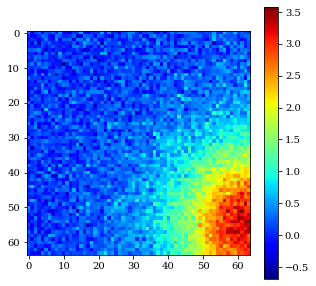

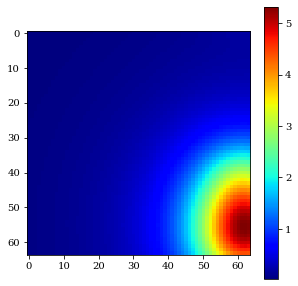

In [8]:
index = np.random.choice(2000)+1
modeltest = 'model{}.npy'.format(str(index))
testfile = os.path.join(os.getcwd(), 'traindatasetsSingleHeight_noise_adj', "models", modeltest)
readdata = np.load(testfile)
print(np.shape(readdata))
filedimag(readdata[0])
filedimag(readdata[1])

In [12]:
data_length = 2000
DA = data_get.DensityDataset()
DaGet = GravDecoder()
DaGet.gen_kernel_eigs()
fie_c = np.zeros((3, 64, 64))
for i in range(data_length):

    #depthz = -1 * np.random.choice([1000, 2000, 4000, 6000, 8000, 10000])
    depthz = -500
    density = DA.data()
    field = DaGet.forward(data_input = density)

    DaGet_Down = GravDecoder_changedepth()
    DaGet_Down.gen_kernel_eigs(depthz = depthz)
    field_downcontinue = DaGet_Down.forward(data_input = density)
    
    fie_c[2, : , : ] = field
    fie_c[1, : , : ] =int(depthz)
    fie_c[0, : , : ] = field_downcontinue

    fieldname = 'model{}.npy'.format(str(i+1))
    fieldpath = os.path.join(os.getcwd(), 'vaatasetsSingleHeight', "models", fieldname)
    np.save(fieldpath, np.array(fie_c))
    if i % 5000 == 0:
        print(i)

0


In [12]:
import torch

# Instantiate your model. This is just a regular PyTorch model that will be exported in the following steps.
model = 'models/checkpointSH.pt'
# Evaluate the model to switch some operations from training mode to inference.
model.eval()
# Create dummy input for the model. It will be used to run the model inside export function.
dummy_input = torch.randn(1, 3, 224, 224)
# Call the export function
torch.onnx.export(model, (dummy_input, ), 'model.onnx')

AttributeError: 'str' object has no attribute 'eval'